In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
__file__ = os.path.abspath('')
dir_path = '/'.join(os.path.realpath(__file__).split('/')[:-1])
sys.path.append(f'{dir_path}/sabatinilab-glm/backend')
sys.path.append(f'{dir_path}/..')
sys.path.append(f'{dir_path}/backend')
sys.path.append(f'{dir_path}/../backend')
# sys.path.append('./backend')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GroupShuffleSplit

import sglm
import sglm_cv
import sglm_pp
import sglm_ez

In [3]:
import pandas as pd



filename = 'dlight_only_WT35_12212020.csv'
# filename = 'dlight_only_WT36_12212020.csv'
# filename = 'Ach_only_WT53L_09032021xlsx.csv'
# filename = 'Ach_only_WT60R_10042021xlsx.csv'

df = pd.read_csv(f'../{filename}')


df = df[[_ for _ in df.columns if 'Unnamed' not in _]]

# .drop('Unnamed: 16', axis=1).drop('Unnamed: 17', axis=1) # .drop('index', axis=1)

print(df.columns)

df = df.rename({'center port occupancy': 'cpo',
                'center port entry': 'cpn',
                'center port exit': 'cpx',

                'left port occupancy': 'lpo',
                'left port entry': 'lpn',
                'left port exit': 'lpx',
                'left licks': 'll',

                'right port occupancy': 'rpo',
                'right port entry': 'rpn',
                'right port exit': 'rpx',
                'right licks': 'rl',

                'no reward': 'nr',
                'reward': 'r',

                'dF/F green (Ach3.0)': 'gdFF',
                'zscored green (Ach3.0)': 'zsgdFF',

                'dF/F green (dLight1.1)': 'gdFF',
                'zscored green (dLight1.1)': 'zsgdFF'
                }, axis=1)

df['event_col_a'] = ((df['cpo'].diff() > 0)*1).replace(0, np.nan) * 1.0
df['event_col_b'] = df['nr'].replace(0, np.nan) * 2.0
df['event_col_c'] = df['r'].replace(0, np.nan) * 3.0

df['event_col'] = df['event_col_a'].combine_first(df['event_col_b']).combine_first(df['event_col_c'])

df = df.drop(['event_col_a', 'event_col_b', 'event_col_c'], axis=1)

df['event_col'] = df['event_col'].bfill()
df['trial_start_flag'] = (df['event_col'] == 1.0)&(df['event_col'].shift(-1) != df['event_col']) * 1.0

df['nTrial'] = df['trial_start_flag'].cumsum().shift(-10).ffill()


Index(['time (msec)', 'center port entry', 'center port occupancy',
       'center port exit', 'left port entry', 'left port occupancy',
       'left port exit', 'left licks', 'right port entry',
       'right port occupancy', 'right port exit', 'right licks', 'no reward',
       'reward', 'dF/F green (dLight1.1)', 'zscored green (dLight1.1)'],
      dtype='object')


In [4]:
import numpy as np

df['event_col_a'] = ((df['cpo'].diff() > 0)*1).replace(0, np.nan) * 1.0
df['event_col_b'] = (df['nr']).replace(0, np.nan) * 2.0
df['event_col_c'] = (df['r']).replace(0, np.nan) * 3.0
df['event_col_d'] = ((df['lpx'] > 0)*1.0).replace(0, np.nan) * 1.0
df['event_col_e'] = ((df['rpx'] > 0)*1.0).replace(0, np.nan) * 1.0

df['event_col_start'] = df['event_col_a'].combine_first(df['event_col_b']).combine_first(df['event_col_c'])

# df = df.drop(['event_col_a', 'event_col_b', 'event_col_c'], axis=1)

df['event_col_start'] = df['event_col_start'].bfill()
df['trial_start_flag'] = ((df['event_col_start'] == 1.0)&(df['event_col_start'].shift(-1) != df['event_col_start']) * 1.0).shift(-5) * 1.0
df['nTrial'] = df['trial_start_flag'].cumsum()

df['event_col_end'] = df['event_col_d'].combine_first(df['event_col_e']).combine_first(df['trial_start_flag'].replace(0.0, np.nan)*2.0)
df['event_col_end'] = df['event_col_end'].ffill()
# df['trial_end_flag'] = ((df['event_col_start'] != 1.0)&(df['event_col_start'].shift(-1) == 1.0)&(df['event_col_start'].shift(-1) != df['event_col_start']) * 1.0).shift(5) * 1.0
df['trial_end_flag'] = ((df['event_col_end'] == 1.0)&(df['event_col_end'].shift(1) == 2.0)&(df['event_col_end'].shift(1) != df['event_col_end'])&(df['nTrial'] > 0) * 1.0).shift(5) * 1.0
df['nEndTrial'] = df['trial_end_flag'].cumsum()


In [5]:
df['trial_start_flag'] = (df['event_col'] == 1.0)&(df['event_col'].shift(-1) != df['event_col']) * 1.0
df

,time (msec),cpn,cpo,cpx,lpn,lpo,lpx,ll,rpn,rpo,...,nTrial,event_col_a,event_col_b,event_col_c,event_col_d,event_col_e,event_col_start,event_col_end,trial_end_flag,nEndTrial
0,50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
1,100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
2,150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
3,200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
4,250,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36994,1849750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0,234
36995,1849800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0,234
36996,1849850,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0,234
36997,1849900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0,234


In [6]:
# y_setup_col = 'rdFF' # photometry response
# df = sglm_ez.diff_cols(df, ['rdFF'])

df['wi_trial_flag'] = (df['nTrial'] != df['nEndTrial'])&(~df['nTrial'].isna())&(~df['nEndTrial'].isna())

X_cols = [
    'nTrial',
    'nEndTrial',
    # 'wi_trial_flag',
    #'cpo',
    'cpn', 'cpx',
    #'lpo',
    'lpn', 'rpn',
    #'rpo',
    'lpx', 'rpx',
    'll', 'rl',
    # 'nr', 'r'
]
ignore_cols = ['r', 'nr', 'wi_trial_flag']

# y_col = 'gdFF'
y_col = 'zsgdFF'
# y_col = 'grnR'

dfrel = df[X_cols + ignore_cols + [y_col]].copy()
dfrel = dfrel.replace('False', 0).astype(float)
dfrel = dfrel*1

dfrel['wi_trial_flag'] = dfrel['wi_trial_flag'].astype(bool)

print(dfrel)
print(X_cols)

neg_order = -10
pos_order = 10

       nTrial  nEndTrial  cpn  cpx  lpn  rpn  lpx  rpx   ll   rl    r   nr  \
0         0.0        NaN  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1         0.0        NaN  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2         0.0        NaN  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3         0.0        NaN  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4         0.0        NaN  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...       ...        ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
36994     NaN      234.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
36995     NaN      234.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
36996     NaN      234.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
36997     NaN      234.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
36998     NaN      234.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

       wi_trial_flag  zsgdFF  
0              False     0.0  
1

In [7]:
# dfrel = dfrel.copy()
# dfrel['wi_trial_flag'] = dfrel['wi_trial_flag'].astype(bool)
# # dfrel = dfrel[dfrel['nTrial'] > 0]
# dfrel = dfrel.dropna()
# dfrel.drop('zsgdFF', axis=1).to_csv('lynne_for_tensor_regression_X.csv')
# dfrel['zsgdFF'].to_csv('lynne_for_tensor_regression_y.csv')
# (dfrel.isna().sum(axis=1)*1).plot()


In [8]:
dfrel = sglm_ez.timeshift_cols(dfrel, X_cols[2:], neg_order=neg_order, pos_order=pos_order)
X_cols_sftd = sglm_ez.add_timeshifts_to_col_list(X_cols, X_cols[2:], neg_order=neg_order, pos_order=pos_order)
dfrel = dfrel.dropna()
X_setup = dfrel[X_cols_sftd].copy()
y_setup = dfrel[y_col].copy()

In [9]:
holdout = sglm_ez.holdout_split_by_trial_id(X_setup, y_setup, id_cols=['nTrial'], perc_holdout=0.2)

X_tr = X_setup[~holdout]
y_tr = y_setup[~holdout]

X_te = X_setup[holdout]
y_te = y_setup[holdout]

tr_keep = (X_tr['nTrial'] != X_tr['nEndTrial'])
te_keep = (X_te['nTrial'] != X_te['nEndTrial'])

X_tr = X_tr[tr_keep]
y_tr = y_tr[tr_keep]
X_te = X_te[te_keep]
y_te = y_te[te_keep]

best_params = {'max_iter': 1000, 'alpha': 0.001, 'l1_ratio': 0.01, 'fit_intercept': True}
glm = sglm_ez.fit_GLM(X_tr, y_tr, **best_params)

In [10]:

print('Score:',
    glm.model.score(X_tr, y_tr),
    glm.model.score(X_te, y_te),
    # glm.model.score(X_tr[tr_keep], y_tr[tr_keep]),
    # glm.model.score(X_te[te_keep], y_te[te_keep])
)

Score: 0.2440474993678886 0.21655336326539953


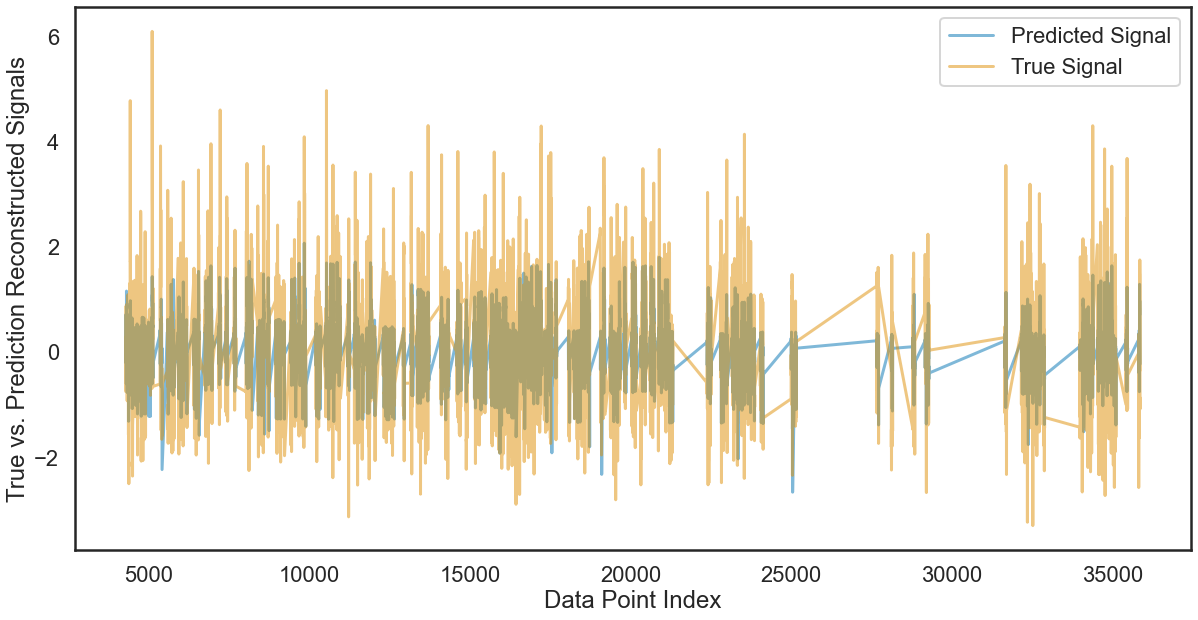

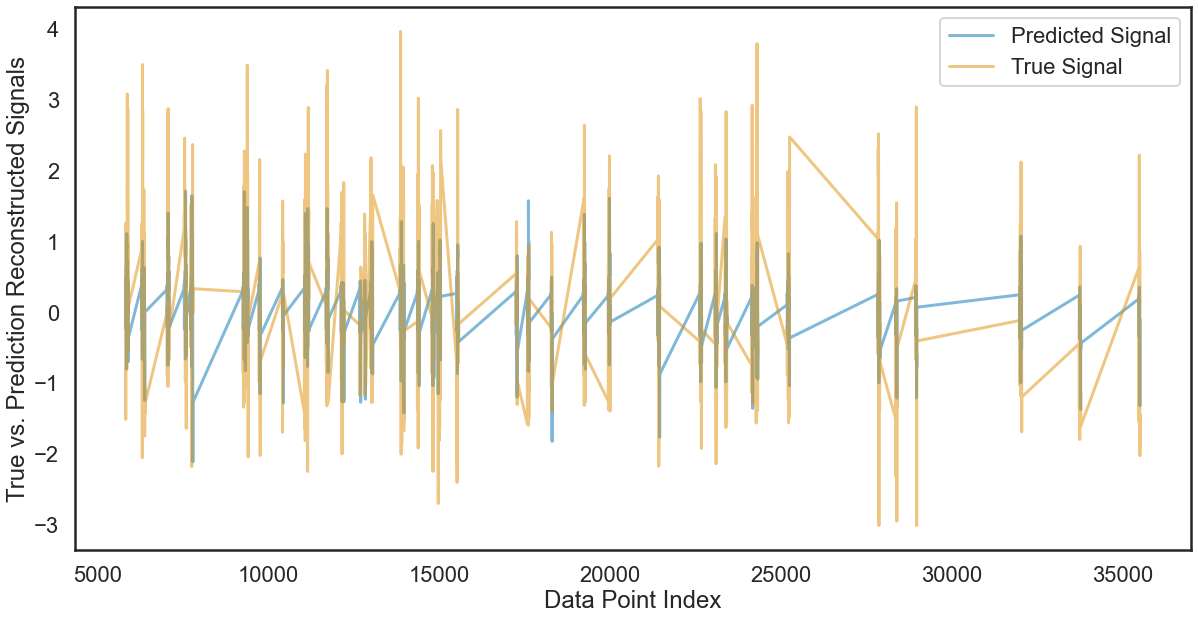

In [11]:
X_tr_nand = X_tr.copy()
# X_tr_nand[~tr_keep] = 0
X_te_nand = X_te.copy()
# X_te_nand[~te_keep] = 0
y_tr_nand = y_tr.copy()
# y_tr_nand[~tr_keep] = glm.intercept_
y_te_nand = y_te.copy()
# y_te_nand[~te_keep] = glm.intercept_


# sglm_ez.reconstruct_signal(glm, X_tr.iloc[5000:10000], y_tr.iloc[5000:10000])
_ = sglm_ez.reconstruct_signal(glm, X_tr_nand, y_tr_nand)
# plt.plot(X_tr['nTrial'].diff())
_ = sglm_ez.reconstruct_signal(glm, X_te_nand, y_te_nand)


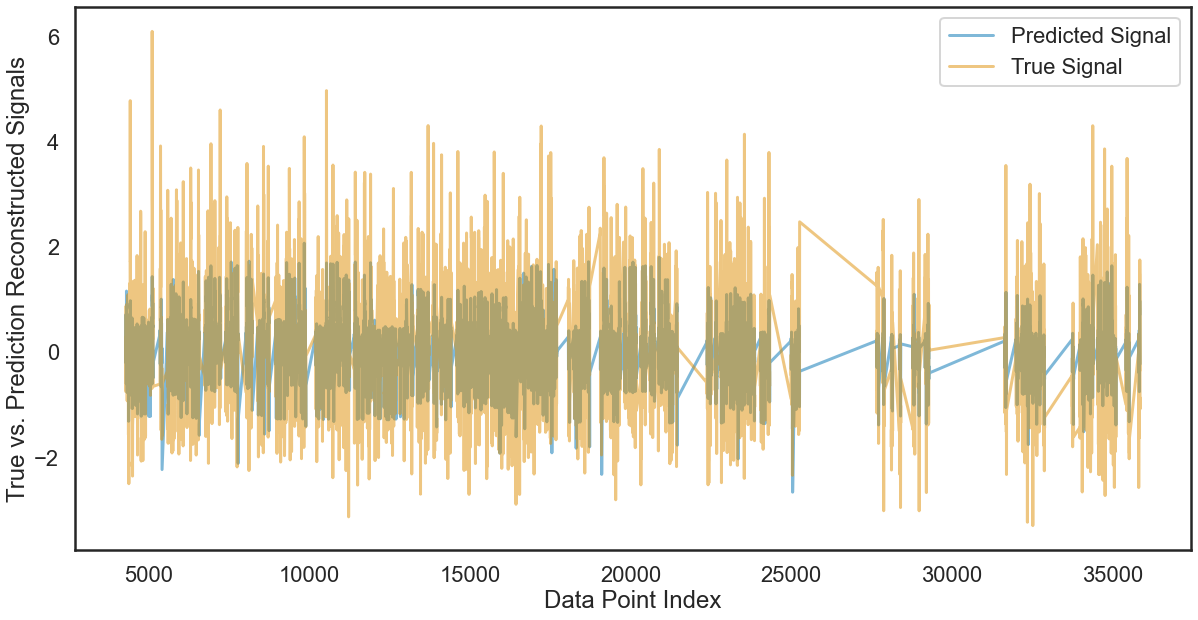

In [12]:
# Full_reconstruction

full_keep = X_setup['nTrial'] != X_setup['nEndTrial']
# full_keep = ((X_setup['nTrial'] != X_setup['nEndTrial'])*0 + 1).astype(bool)

y_true_full, y_hat_full = sglm_ez.reconstruct_signal(glm, X_setup[full_keep], y_setup[full_keep])



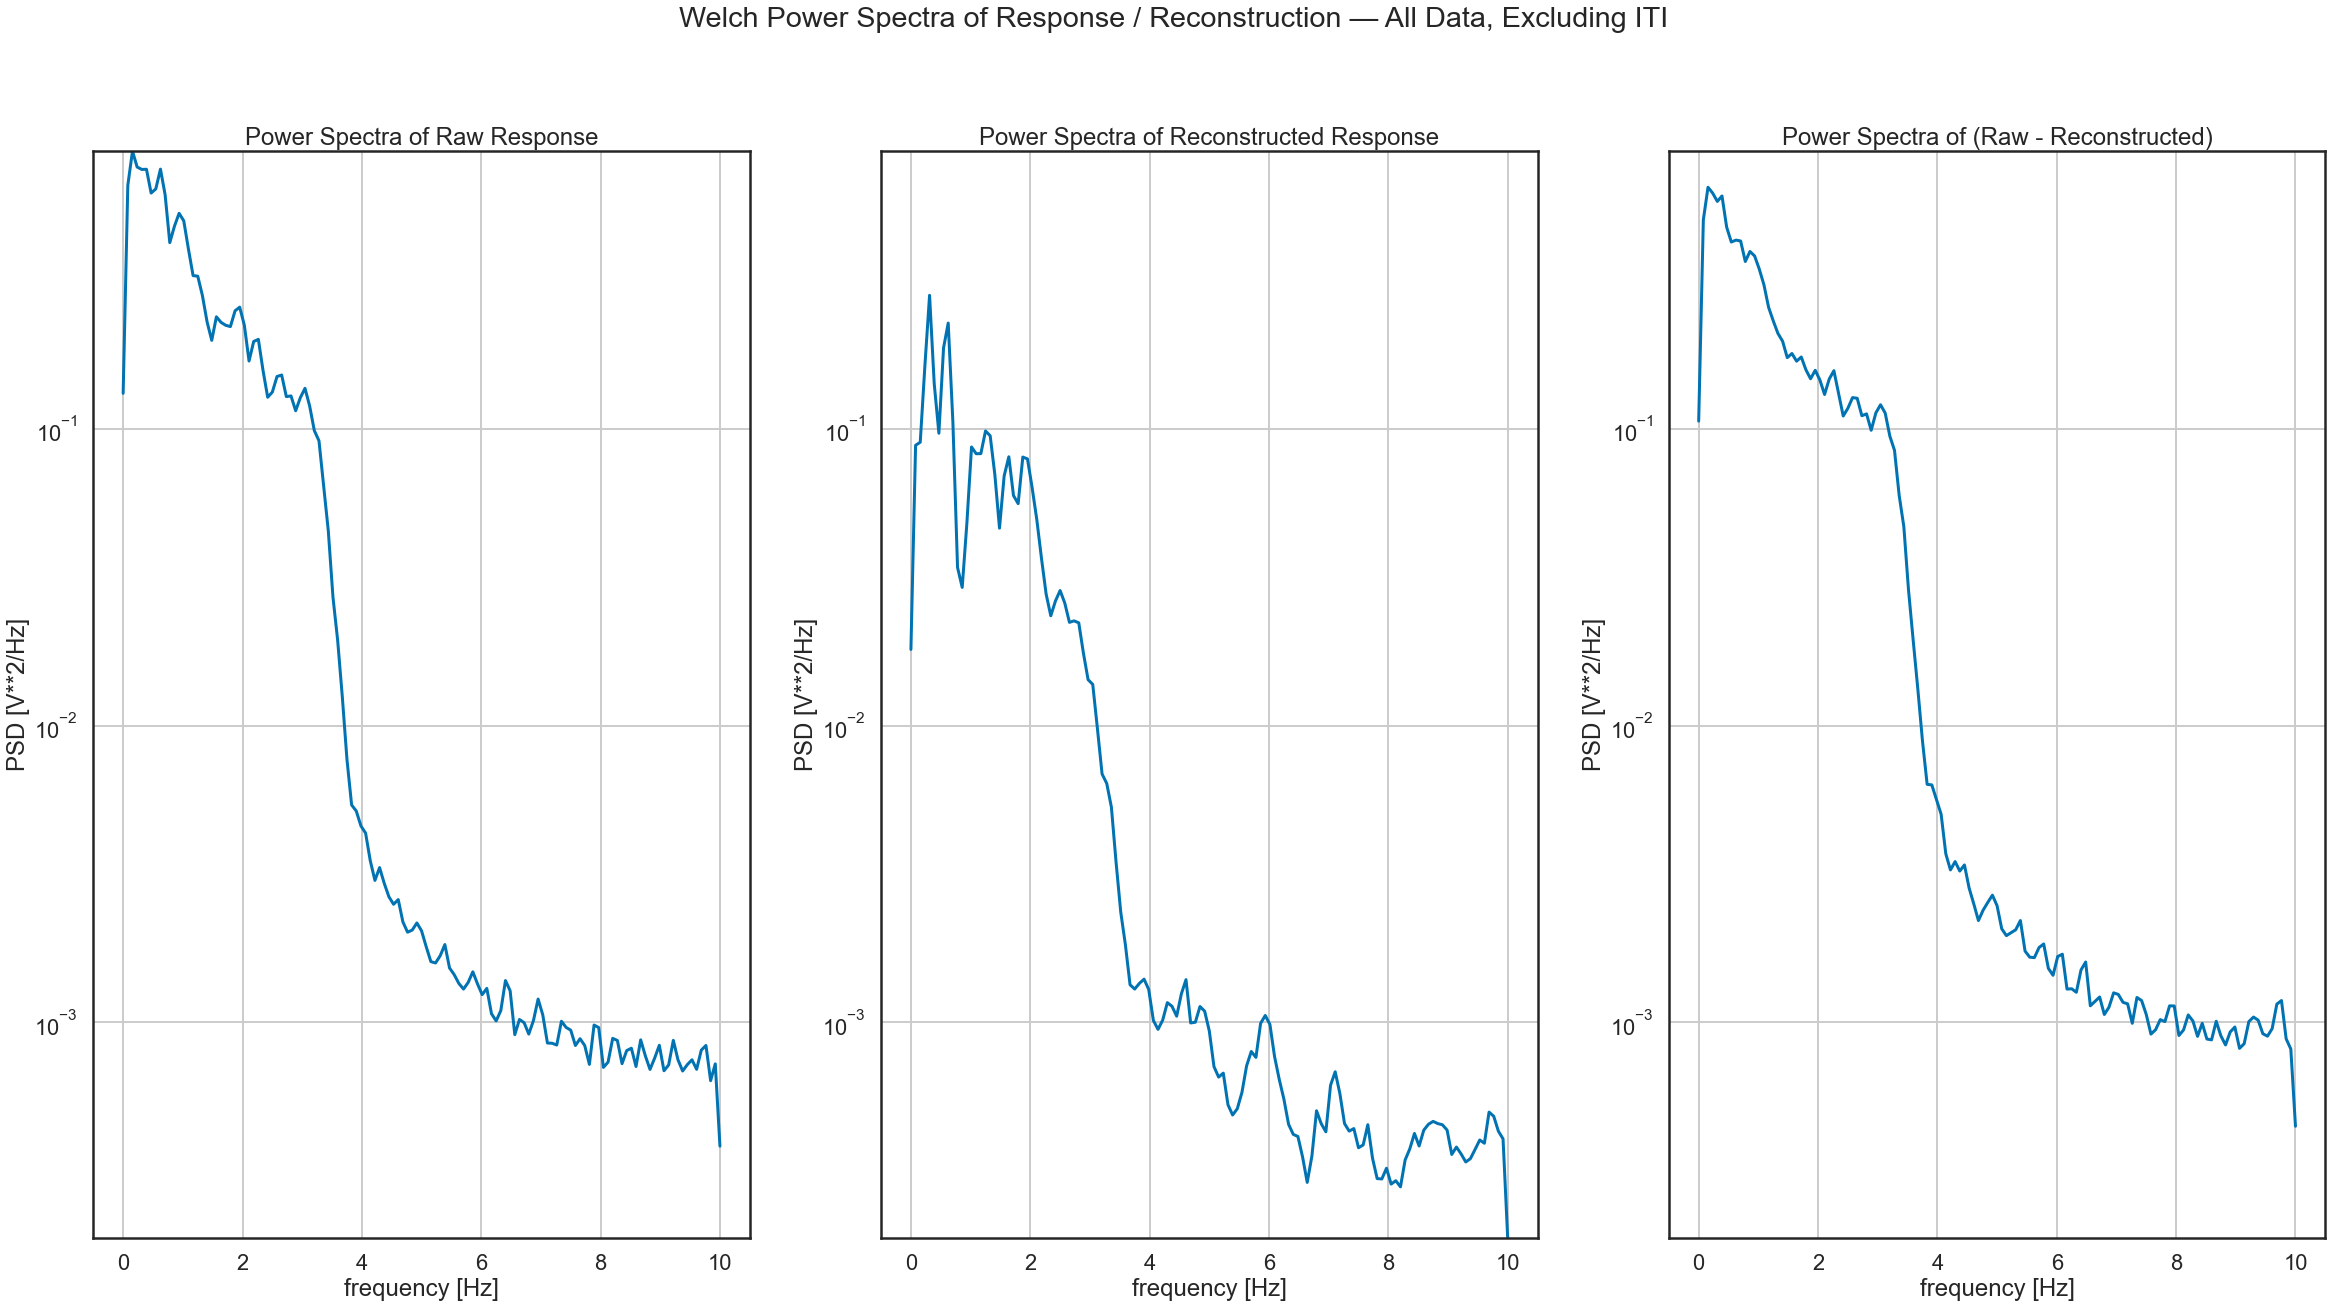

In [13]:
from scipy.fft import fft, ifft

fft_ytrue = np.abs(fft(y_true_full.values))
fft_yhat = np.abs(fft(y_hat_full))

# fig, ax = plt.subplots(1,3)
# fig.set_figheight(20)
# fig.set_figwidth(40)
# ax[0].plot(fft_ytrue)
# ax[0].set_title('FFT of Raw Response')
# ax[1].plot(fft_yhat)
# ax[1].set_title('FFT of Reconstructed Response')
# ax[2].plot(fft_ytrue - fft_yhat)
# ax[2].set_title('FFT Raw - FFT Reconstructed')

from scipy.signal import welch
f_true, Pxx_den_true = welch(y_true_full.values, fs=20)
f_hat, Pxx_den_hat = welch(y_hat_full, fs=20)
f_resid, Pxx_den_resid = welch(y_true_full - y_hat_full, fs=20)

y_lim_min = np.min([*Pxx_den_true, *Pxx_den_hat, *Pxx_den_resid])
y_lim_max = np.max([*Pxx_den_true, *Pxx_den_hat, *Pxx_den_resid])
y_lims = (y_lim_min, y_lim_max)

x_lim_min = np.min([*f_true, *f_hat, *f_resid])
x_lim_max = np.max([*f_true, *f_hat, *f_resid])
x_lims = (x_lim_min, x_lim_max)

fig, ax = plt.subplots(1,3)
fig.suptitle('Welch Power Spectra of Response / Reconstruction — All Data, Excluding ITI')
fig.set_figheight(20)
fig.set_figwidth(40)


ax[0].semilogy(f_true, Pxx_den_true)
# plt.ylim([0.5e-3, 1])
ax[0].set_xlabel('frequency [Hz]')
ax[0].set_ylabel('PSD [V**2/Hz]')
ax[0].set_ylim(y_lims)
ax[0].set_title('Power Spectra of Raw Response')
ax[0].grid()

ax[1].semilogy(f_hat, Pxx_den_hat)
ax[1].set_xlabel('frequency [Hz]')
ax[1].set_ylabel('PSD [V**2/Hz]')
ax[1].set_ylim(y_lims)
ax[1].set_title('Power Spectra of Reconstructed Response')
ax[1].grid()


ax[2].semilogy(f_resid, Pxx_den_resid)
ax[2].set_xlabel('frequency [Hz]')
ax[2].set_ylabel('PSD [V**2/Hz]')
ax[2].set_ylim(y_lims)
ax[2].set_title('Power Spectra of (Raw - Reconstructed)')
ax[2].grid()

plt.show()

fig.savefig('figure_outputs/spectral_out.png')


(-0.7639459582587782, 0.6783991262138344)
0
1
2
3
4
5
6
7


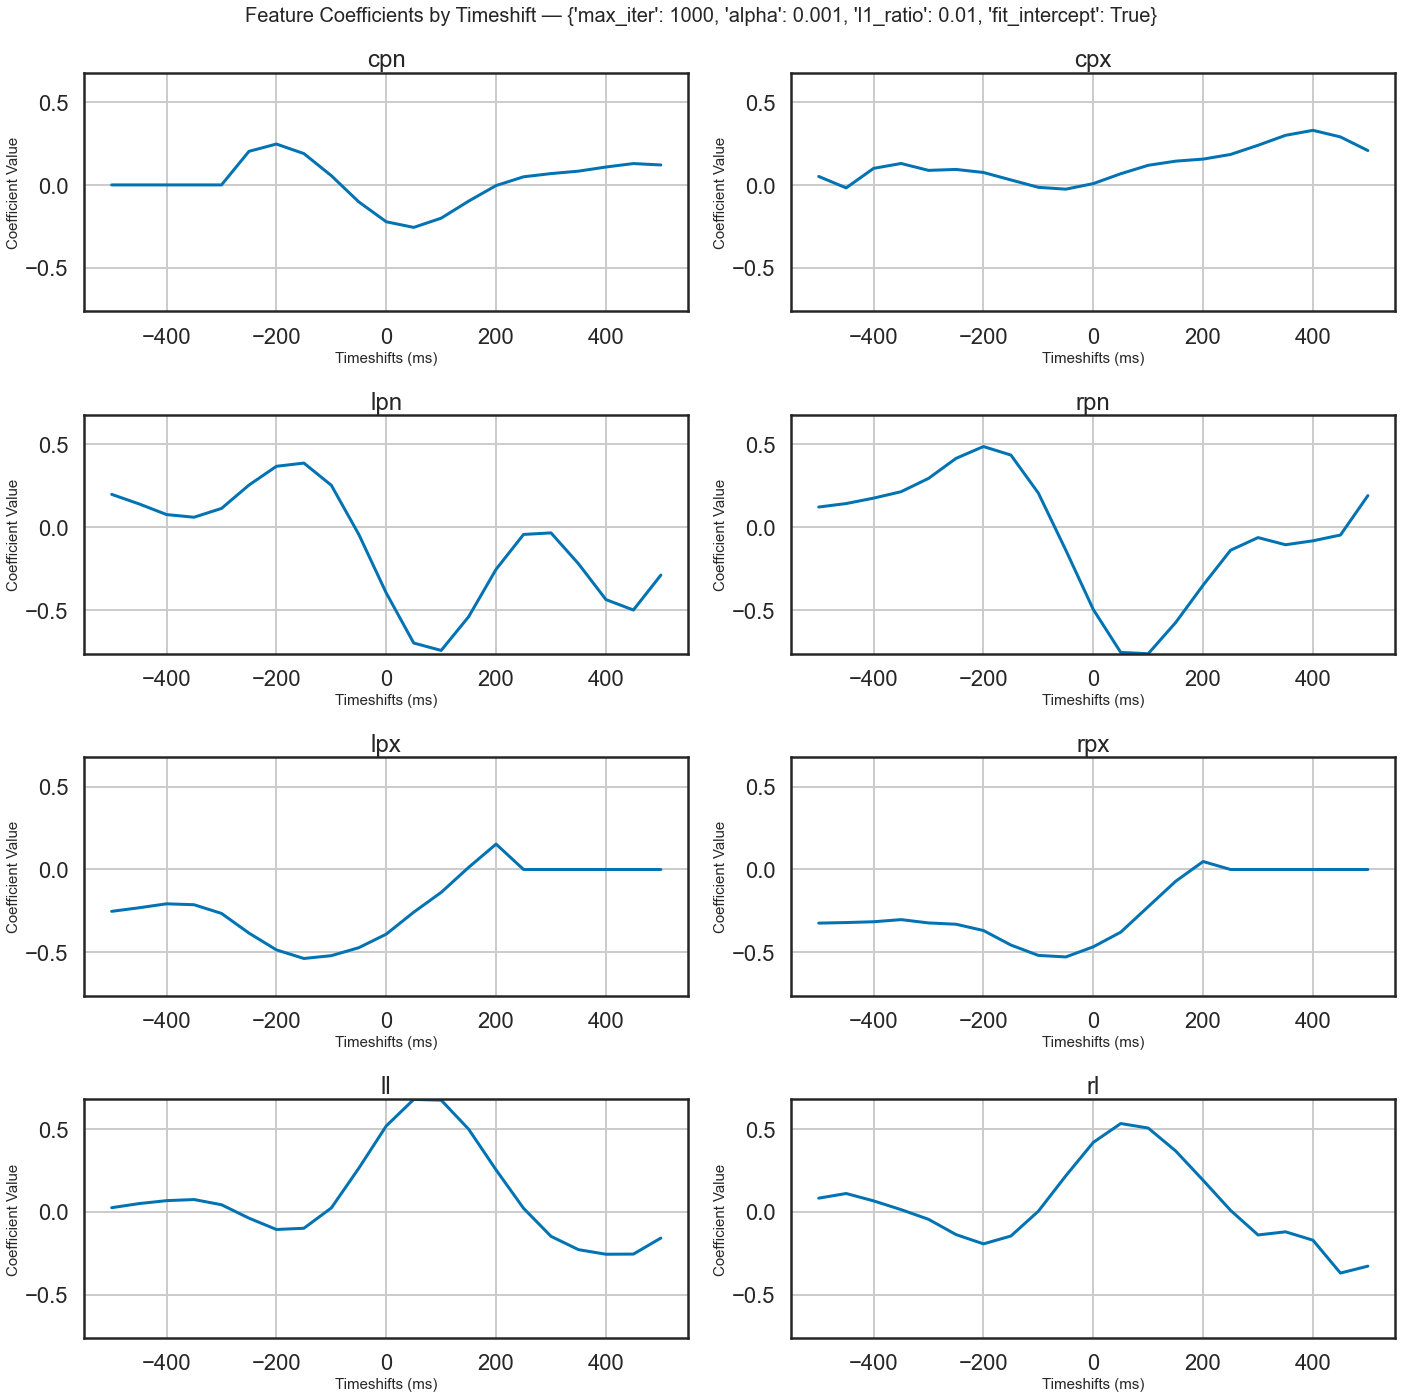

In [14]:
sglm_ez.plot_all_beta_coefs(glm, X_cols, X_cols_sftd, plot_width=2, plot_name=str(glm.kwargs), binsize=50, filename='figure_outputs/beta_coeffs.png')

In [15]:
# sglm_ez.plot_all_beta_coefs(glm, X_cols, X_cols_sftd, plot_width=2)


In [16]:

# Step 1: Create a dictionary of lists for these relevant keywords...
kwargs_iterations = {
    # 'alpha': reversed([0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]),
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
    'l1_ratio': [0.0001, 0.001, 0.01, 0.1, 0.5, 0.9, 0.99]
}

# Step 2: Create a dictionary for the fixed keyword arguments that do not require iteration...
kwargs_fixed = {
    'max_iter': 1000,
    'fit_intercept': True
}

score_method = 'r2'

# Step 3: Generate iterable list of keyword sets for possible combinations
glm_kwarg_lst = sglm_cv.generate_mult_params(kwargs_iterations, kwargs_fixed)

In [17]:
tmp = dfrel[holdout]
tmp = tmp[(tmp['nTrial'] != tmp['nEndTrial'])].copy()
tmp['1'] = 1
tmp['tim'] = tmp.groupby('nTrial')['1'].cumsum()
tmp['pred'] = glm.predict(tmp[X_cols_sftd])


In [18]:
(tmp.groupby('nTrial')['rpn'].agg(lambda x: x.argmax()) > 0).sum() + \
(tmp.groupby('nTrial')['lpn'].agg(lambda x: x.argmax()) > 0).sum()

43

In [19]:
# entry_timing_r = tmp.groupby('nTrial')['rpn'].agg([lambda x: x.argmax(), np.size]).astype(int)
# entry_timing_l = tmp.groupby('nTrial')['lpn'].agg([lambda x: x.argmax(), np.size]).astype(int)
entry_timing_r = tmp.groupby('nTrial')['rpn'].agg(lambda x: x.argmax()).astype(int)
entry_timing_l = tmp.groupby('nTrial')['lpn'].agg(lambda x: x.argmax()).astype(int)
entry_timing = (entry_timing_r > entry_timing_l)*entry_timing_r + (entry_timing_r < entry_timing_l)*entry_timing_l

In [20]:
# tmp[tmp['adjusted_time'] < -70]

In [21]:
# dfrel[dfrel['nTrial'] == 217.0][['cpn', 'cpx', 'lpn', 'lpx', 'rpn', 'rpx', 'r', 'nr']].plot()

In [22]:
adjusted_time = (tmp.set_index('nTrial')['tim'] - entry_timing)
adjusted_time.index = tmp.index
tmp['adjusted_time'] = adjusted_time
# tmp.iloc[:50]

In [23]:
adjusted_time.min()

-50

In [24]:
def get_is_trial(X, gb_name=['nTrial'], col_names=['r']):
    for icol, col in enumerate(col_names):
        if icol == 0:
            check_list = (X.groupby(gb_name)[col].transform(np.max) == 1)
        else:
            check_list = check_list&(X.groupby(gb_name)[col].transform(np.max) == 1)
    return check_list

In [25]:
tmp_backup = tmp

In [26]:
def get_sem(df, filt, gb, col, mult=1.96):
    interim = df[filt].groupby(gb)[col].agg([np.mean, np.std, np.size])
    interim['sem'] = interim['std'] / np.sqrt(interim['size'])
    interim['ub'] = interim['mean'] + 1.96*interim['sem']
    interim['lb'] = interim['mean'] - 1.96*interim['sem']
    return interim[['lb', 'mean', 'ub', 'sem', 'size', 'std']]

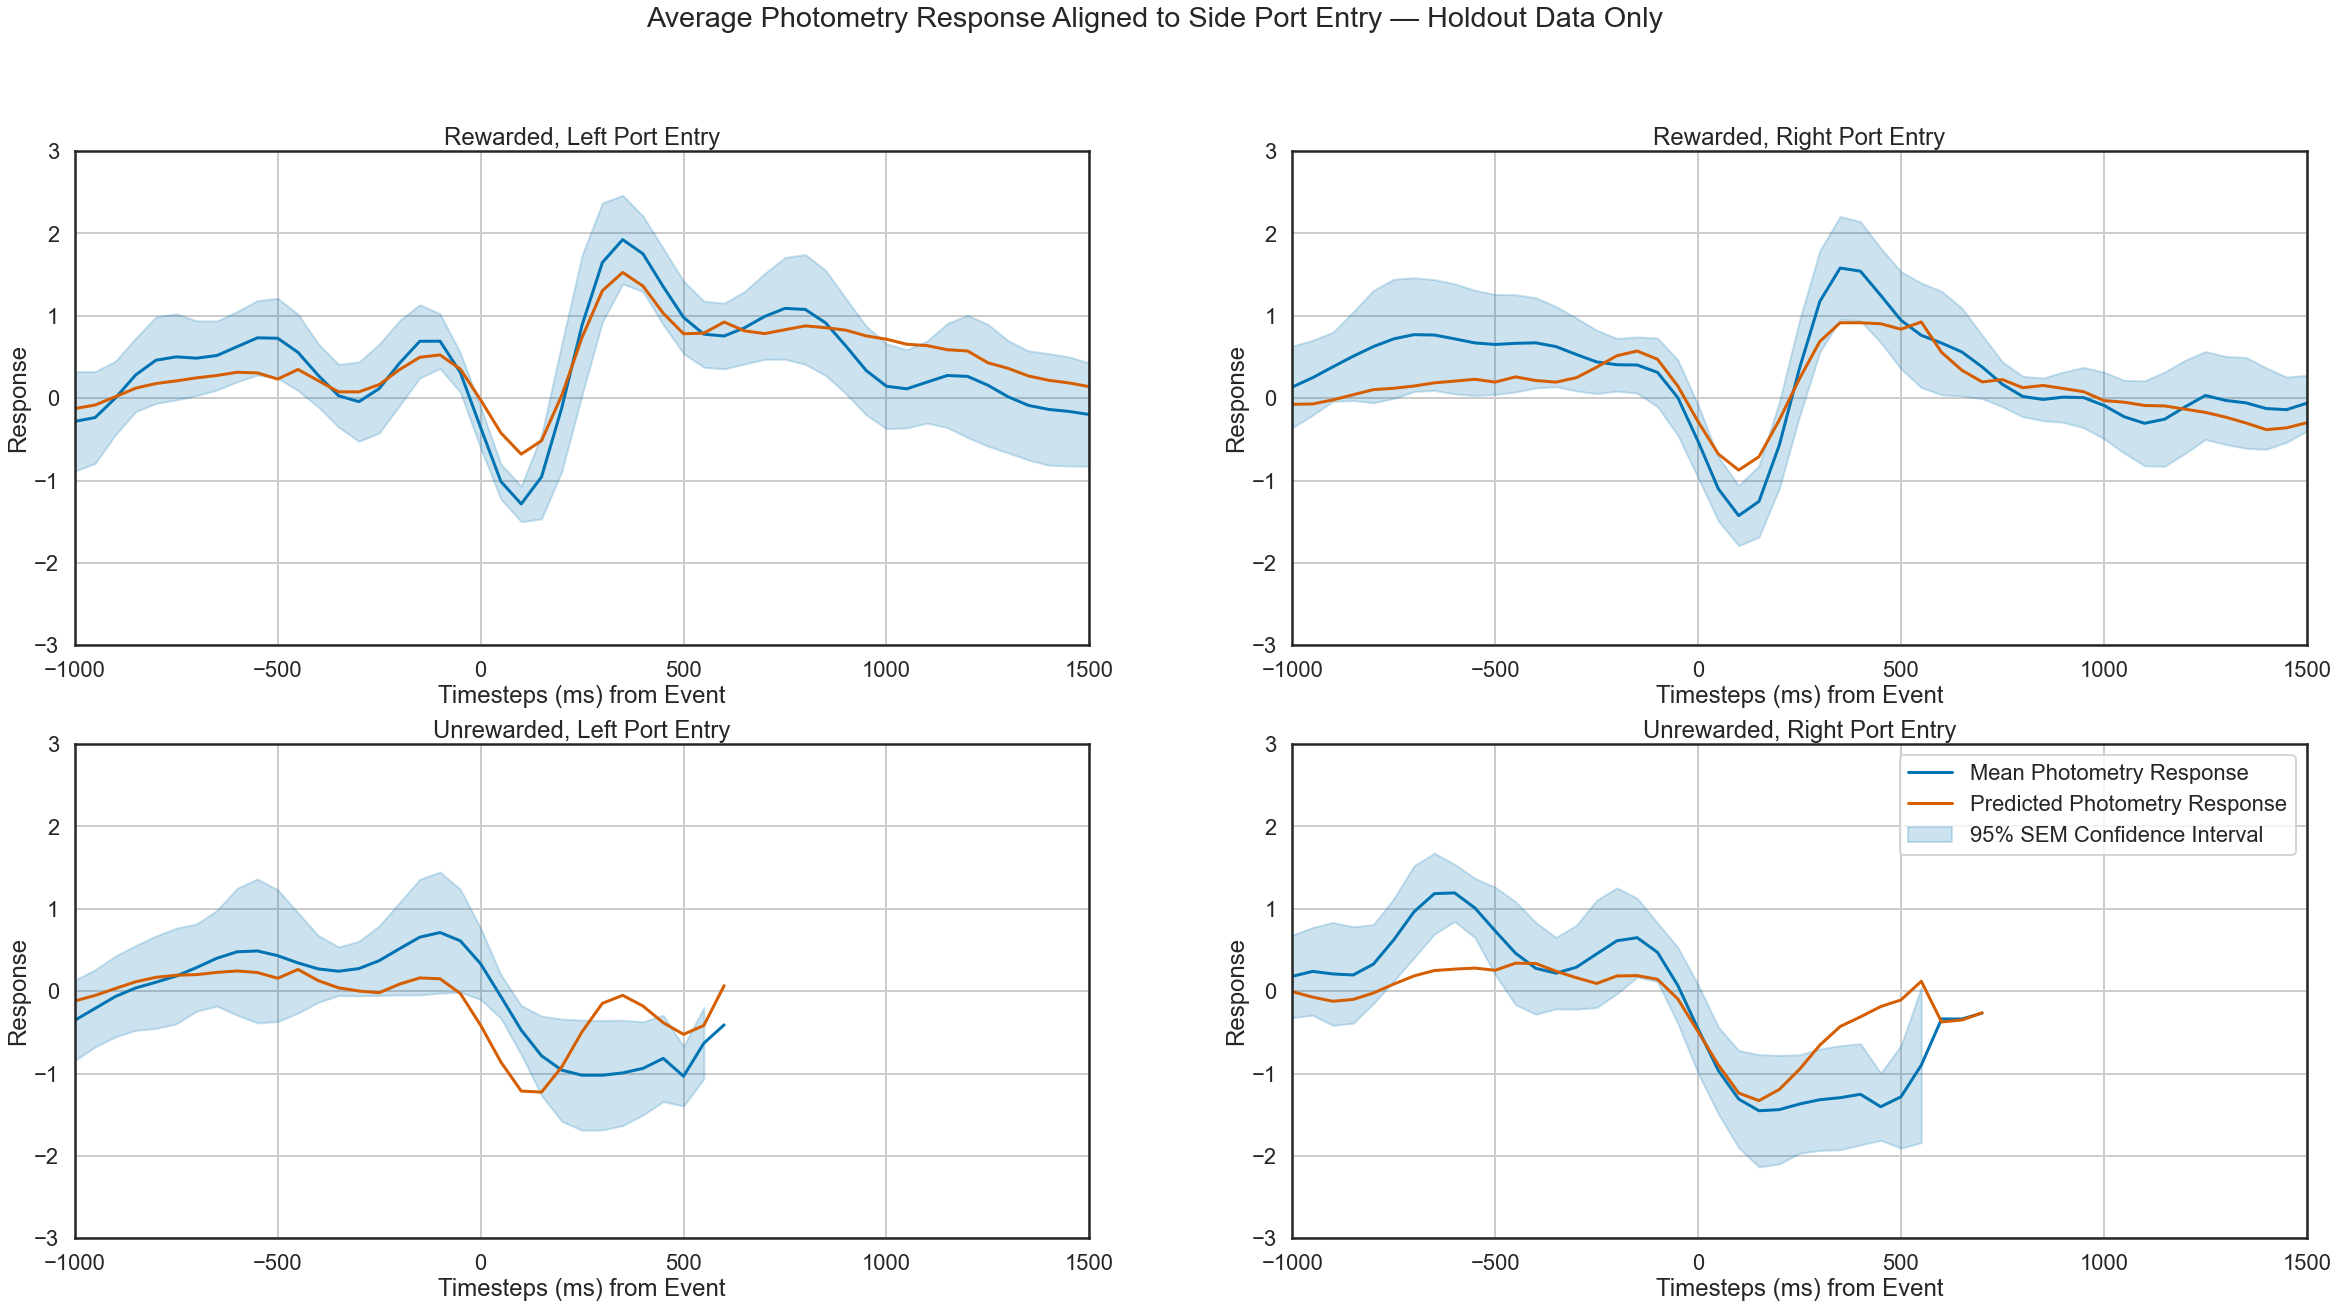

In [27]:
binsize = 50

min_time = -20
max_time = 30
min_signal = -3.0
max_signal = 3.0

x_label = 'Timesteps __ from Event'
y_label = 'Response'

if binsize is not None:
    min_time *= binsize
    max_time *= binsize
    x_label = x_label.replace(' __', ' (ms)')
    tmp_backup['plot_time'] = tmp_backup['adjusted_time'] * binsize
else:
    x_label = x_label.replace(' __', '')
    tmp_backup['plot_time'] = tmp_backup['adjusted_time']



tmp = tmp_backup[tmp_backup['plot_time'].between(min_time, max_time)].copy()


# plt.figure(figsize=(10,5))
fig, ax = plt.subplots(2,2)
fig.suptitle('Average Photometry Response Aligned to Side Port Entry — Holdout Data Only')
fig.set_figheight(20)
fig.set_figwidth(40)

tmp['is_rlpn_trial'] = get_is_trial(tmp, ['nTrial'], ['r', 'lpn'])
tmp['is_rrpn_trial'] = get_is_trial(tmp, ['nTrial'], ['r', 'rpn'])
tmp['is_nrlpn_trial'] = get_is_trial(tmp, ['nTrial'], ['nr', 'lpn'])
tmp['is_nrrpn_trial'] = get_is_trial(tmp, ['nTrial'], ['nr', 'rpn'])

# rgb = tmp[tmp['is_rlpn_trial']].groupby(['plot_time'])['zsgdFF'].mean().plot()
ci_setup = get_sem(tmp, tmp['is_rlpn_trial'], 'plot_time', 'zsgdFF')
ax[0,0].plot(ci_setup['mean'], color='b')
ax[0,0].fill_between(ci_setup.index, ci_setup['lb'], ci_setup['ub'], color='b', alpha=.2)

ci_setup = get_sem(tmp, tmp['is_rlpn_trial'], 'plot_time', 'pred')
ax[0,0].plot(ci_setup['mean'], color='r')


ax[0,0].set_xlim((min_time, max_time))
ax[0,0].set_ylim((min_signal, max_signal))
ax[0,0].title.set_text('Rewarded, Left Port Entry')
ax[0,0].set_xlabel(x_label)
ax[0,0].set_ylabel(y_label)
ax[0,0].grid()
# print(ci_setup.iloc[-1])

# # plt.figure(figsize=(10,5))
# fig, ax = plt.subplots()
# fig.set_figheight(5)
# fig.set_figwidth(10)
ci_setup = get_sem(tmp, tmp['is_rrpn_trial'], 'plot_time', 'zsgdFF')
ax[0,1].plot(ci_setup['mean'])
ax[0,1].fill_between(ci_setup.index, ci_setup['lb'], ci_setup['ub'], color='b', alpha=.2)

ci_setup = get_sem(tmp, tmp['is_rrpn_trial'], 'plot_time', 'pred')
ax[0,1].plot(ci_setup['mean'], color='r')



ax[0,1].set_xlim((min_time, max_time))
ax[0,1].set_ylim((min_signal, max_signal))
ax[0,1].title.set_text('Rewarded, Right Port Entry')
ax[0,1].set_xlabel(x_label)
ax[0,1].set_ylabel(y_label)
ax[0,1].grid()
# print(ci_setup.iloc[-1])

# # plt.figure(figsize=(10,5))
# fig, ax = plt.subplots()
# fig.set_figheight(5)
# fig.set_figwidth(10)
ci_setup = get_sem(tmp, tmp['is_nrlpn_trial'], 'plot_time', 'zsgdFF')
ax[1,0].plot(ci_setup['mean'])
ax[1,0].fill_between(ci_setup.index, ci_setup['lb'], ci_setup['ub'], color='b', alpha=.2)

ci_setup = get_sem(tmp, tmp['is_nrlpn_trial'], 'plot_time', 'pred')
ax[1,0].plot(ci_setup['mean'], color='r')



ax[1,0].set_xlim((min_time, max_time))
ax[1,0].set_ylim((min_signal, max_signal))
ax[1,0].title.set_text('Unrewarded, Left Port Entry')
ax[1,0].set_xlabel(x_label)
ax[1,0].set_ylabel(y_label)
ax[1,0].grid()
# print(ci_setup.iloc[-1])

# # plt.figure(figsize=(10,5))
# fig, ax = plt.subplots()
# fig.set_figheight(5)
# fig.set_figwidth(10)
ci_setup = get_sem(tmp, tmp['is_nrrpn_trial'], 'plot_time', 'zsgdFF')
ax[1,1].plot(ci_setup['mean'])
ax[1,1].fill_between(ci_setup.index, ci_setup['lb'], ci_setup['ub'], color='b', alpha=.2)

ci_setup = get_sem(tmp, tmp['is_nrrpn_trial'], 'plot_time', 'pred')
ax[1,1].plot(ci_setup['mean'], color='r')



ax[1,1].set_xlim((min_time, max_time))
ax[1,1].set_ylim((min_signal, max_signal))
ax[1,1].title.set_text('Unrewarded, Right Port Entry')
ax[1,1].set_xlabel(x_label)
ax[1,1].set_ylabel(y_label)
ax[1,1].grid()
# print(ci_setup.iloc[-1])

ax[1,1].legend(['Mean Photometry Response',
                'Predicted Photometry Response',
                '95% SEM Confidence Interval'])

fig.savefig('figure_outputs/average_response_reconstruction.png')


In [28]:
glm.r2_score(dfrel[holdout][X_cols_sftd], dfrel[holdout][y_col])

0.03969324172145006

In [29]:
glm.r2_score(dfrel[holdout].query('wi_trial_flag')[X_cols_sftd], dfrel[holdout].query('wi_trial_flag')[y_col])

0.21655336326539953

In [41]:
tmp = dfrel[holdout].copy()
tmp = tmp[(tmp['nTrial'] != tmp['nEndTrial'])]
tmp['1'] = 1
tmp['tim'] = tmp.groupby('nTrial')['1'].cumsum()




tmp2 = dfrel[holdout].copy()
tmp2 = tmp2[(tmp2['nTrial'] != tmp2['nEndTrial'])]
tmp2['tim'] = sglm_ez.get_trial_timestamp(tmp2, trial_id_col='nTrial')

# tmp = dfrel[holdout]
# tmp = tmp[(tmp['nTrial'] != tmp['nEndTrial'])].copy()
# tmp['1'] = 1
# tmp['tim'] = tmp.groupby('nTrial')['1'].cumsum()
tmp2['pred'] = glm.predict(tmp2[X_cols_sftd])

In [45]:
(tmp['tim'] == tmp2['tim']).mean()

1.0

In [95]:
tmp2['rpn_first'] = sglm_ez.get_first_timestamp_abv_threshold(tmp2, 'rpn', trial_id_col='nTrial', threshold=0.0).replace(0, np.nan)
entry_timing_r = tmp.groupby('nTrial')['rpn'].agg(lambda x: (x).argmax()).astype(int)
a = tmp2.set_index('nTrial')['rpn_first'].dropna()
b = entry_timing_r.loc[entry_timing_r.index.isin(a.index)]
((a - b) != 0).sum()

1076

In [96]:
tmp2['lpn_first'] = sglm_ez.get_first_timestamp_abv_threshold(tmp2, 'lpn', trial_id_col='nTrial', threshold=0.0).replace(0, np.nan)
entry_timing_l = tmp.groupby('nTrial')['lpn'].agg(lambda x: (x).argmax()).astype(int)
a = tmp2.set_index('nTrial')['lpn_first'].dropna()
b = entry_timing_l.loc[entry_timing_l.index.isin(a.index)]
((a - b) != 0).sum()


1288

In [101]:
tmp2['side_first'] = tmp2[['lpn_first','rpn_first']].fillna(np.inf).min(axis=1)
# tmp2
entry_timing = (entry_timing_r > entry_timing_l)*entry_timing_r + (entry_timing_r < entry_timing_l)*entry_timing_l

In [108]:
((tmp2.set_index('nTrial')['side_first'] - entry_timing) != 0).sum()

0